In [1]:
import os
import scipy.io
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft

# machine learning parts
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance



In [2]:
def read_mat_files(data_path):
    # List to hold all data
    all_data = []
    all_data_name = []
    # Iterate over each file in the directory
    for file in os.listdir(data_path):
        if file.endswith('.mat'):
            file_path = os.path.join(data_path, file)

            # Load the .mat file
            data = scipy.io.loadmat(file_path)

            # Append the data to the list
            all_data.append(data)
            all_data_name.append(file)

    return all_data, all_data_name

# Specify the data path
data_path = '../../weight_datas/1d_data'

# Call the function to read data
mat_data, mat_data_name = read_mat_files(data_path)

In [4]:
def seperation_signal(signal, fs, thre = 0.5, d_ratio = 0.5):
    distance_between_peaks = fs * d_ratio  # Expected distance between peaks in samples

    # Using the find_peaks function from scipy.signal to detect peaks
    peaks, _ = find_peaks(signal, distance=distance_between_peaks)

    highest_peak_value = np.max(signal[peaks])

    # Define the threshold as 1/3 of the highest peak value
    threshold_value = highest_peak_value * thre

    # Filter out peaks that are lower than the threshold
    filtered_peaks = peaks[signal[peaks] > threshold_value]

    return filtered_peaks

0
6
8
7
5
4
2
3
1


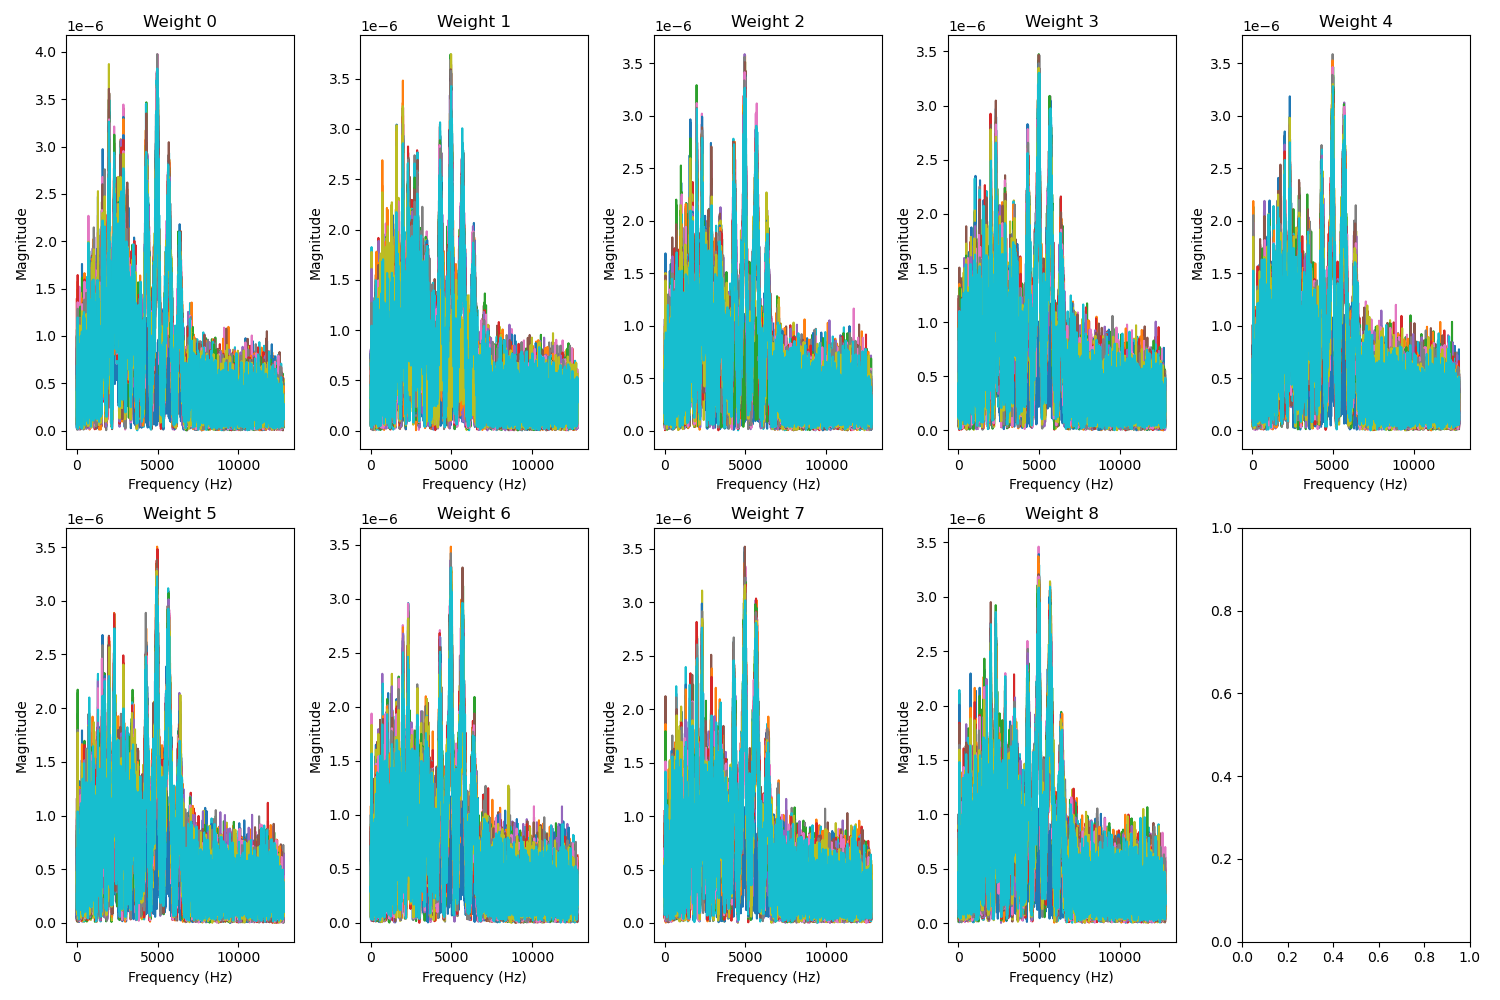

In [19]:
weights = np.arange(0,9,1)
fs = 25600
fig, axs = plt.subplots(2,5, figsize=(15, 10))
for j, w in enumerate(weights):
    if w == 0:
        file_name = 'empty.mat'
    else:
        file_name = 'weight_' + str(w) + '.mat'
    
    idx = np.where(np.array(mat_data_name) == file_name)[0][0]
    print(idx)
    data = mat_data[idx]['data']
    time = np.arange(0, len(data)/fs, 1/fs)

    signal = data[:, 3] - 2.5*1e-4
    filtered_peaks = seperation_signal(signal, fs)
    # Plotting the signal and the detected peaks
    # plt.figure(figsize=(14, 7))
    # plt.plot(time, signal, label='Signal')
    # plt.plot(time[filtered_peaks], signal[filtered_peaks], 'x', label='Detected Peaks')
    # plt.title(f'Signal with Detected Peaks with weight {w}')
    # plt.xlabel('Time (seconds)')
    # plt.ylabel('Amplitude')
    # plt.legend()
    # plt.show()

    time_window = 0.2  # 0.2 seconds on each side of the peak

    # Calculate the number of samples in the time window
    samples_window = int(time_window * fs)

    # FFT analysis on each segment
    fft_segments = []
    frequency_bins = np.fft.fftfreq(samples_window * 2, 1/fs)

    for peak in filtered_peaks:
        # Extract the segment around the peak
        start_index = int(max(peak - samples_window, 0))
        end_index = int(min(peak + samples_window, len(signal)))
        segment = signal[start_index:end_index]

        # Compute FFT of the segment
        segment_fft = fft(segment)

        # Normalize the FFT output
        segment_fft = np.abs(segment_fft) / len(segment_fft)

        # Store the FFT result
        fft_segments.append(segment_fft)

    # Plot all the FFT spectra within one figure
    ax = axs[j // 5, j % 5]
    for i, fft_segment in enumerate(fft_segments):
        ax.plot(frequency_bins[1:len(fft_segment)//2], fft_segment[1:len(fft_segment)//2], label=f'Segment {i+1}')
    # ax.set_xlim([0, 400])
    ax.set_title(f'Weight {w}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
 
plt.tight_layout()
plt.show()

In [52]:
# Extract fft features and labels and use that for the regression model, use the first 160 elements as features
weights = np.arange(0,9,1)
fs = 25600
fft_segments = []
weights_label = []
# fig, axs = plt.subplots(2,5, figsize=(15, 10))
for j, w in enumerate(weights):
    if w == 0:
        file_name = 'empty.mat'
    else:
        file_name = 'weight_' + str(w) + '.mat'
    idx = np.where(np.array(mat_data_name) == file_name)[0][0]
    print(idx)
    data = mat_data[idx]['data']
    time = np.arange(0, len(data)/fs, 1/fs)

    signal = data[:, 3] - 2.5*1e-4
    filtered_peaks = seperation_signal(signal, fs)
    time_window = 0.2  # 0.2 seconds on each side of the peak

    # Calculate the number of samples in the time window
    samples_window = int(time_window * fs)

    # FFT analysis on each segment
    
    frequency_bins = np.fft.fftfreq(samples_window * 2, 1/fs)

    for peak in filtered_peaks:
        # Extract the segment around the peak
        start_index = int(max(peak - samples_window, 0))
        end_index = int(min(peak + samples_window, len(signal)))
        segment = signal[start_index:end_index]

        # Compute FFT of the segment
        segment_fft = fft(segment)

        # Normalize the FFT output
        segment_fft = np.abs(segment_fft) / len(segment_fft)

        # Store the FFT result
        fft_segments.append(segment_fft[1:2000])
        weights_label.append(w)


0
6
8
7
5
4
2
3
1


In [53]:
# For regression task
# Prepare the data
feats = np.array(fft_segments)
y = np.array(weights_label)
X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size = 0.2, random_state = 42)
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.6018437448701865


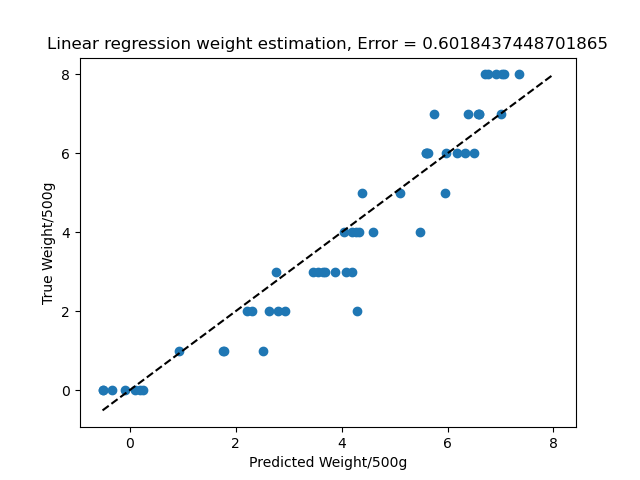

In [56]:
plt.figure()
plt.scatter(y_pred, y_test)
# Calculate the limits for the line
min_val = min(min(y_pred), min(y_test))
max_val = max(max(y_pred), max(y_test))

# Add the x = y reference line
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='x = y')  # 'k--' creates a black dashed line

plt.title(f"Linear regression weight estimation, Error = {mae}")
plt.xlabel("Predicted Weight/500g")
plt.ylabel("True Weight/500g")
plt.show()

In [20]:
np.where(frequency_bins[1:len(fft_segment)//2]<5000)

(array([   0,    1,    2, ..., 1996, 1997, 1998]),)

In [27]:
feats.shape

(270, 1)